## Setup

Load libraries:

In [2]:
import os
import yaml
import torch
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from snowmodels.utils import compare_multiple_models, ecnoder_preprocessor, load_data, model_variant_selector, load_config

xgb_device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"XGBoost will run on {xgb_device}")

XGBoost will run on cpu


## Load Dataset

In [3]:
raw_data=load_data('../data/data_splits.pkl', final_eval=True)
main_config = model_variant_selector(variant='main', data=raw_data)
all_config = load_config(config_path='../experiments/hyperparameters.yaml')

processed_data_cat_main=ecnoder_preprocessor(
    encoder='target',
    cfg=all_config.global_cfg,
    data=main_config
)


X_train_main = processed_data_cat_main.x_train
X_test_main = processed_data_cat_main.x_val
y_train = processed_data_cat_main.y_train
y_test = processed_data_cat_main.y_val

### Extra Trees

In [4]:
with open('../experiments/results/tune_new/extratrees_main_tune_target_20250902_232842.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

ext_hyp_from_optuna = raw_config['performance']['hyperparameters']


ext_trees_main=ExtraTreesRegressor(**ext_hyp_from_optuna, random_state=all_config.global_cfg.seed, n_jobs=all_config.global_cfg.n_jobs)

ext_trees_main.fit(X_train_main, y_train)
y_pred_ext_main = ext_trees_main.predict(X_test_main)

In [84]:
X_train_main.columns

Index(['Elevation', 'Snow_Depth', 'DOWY', 'Latitude', 'Longitude',
       'Snow_Class'],
      dtype='object')

### Random Forest

In [5]:
with open('../experiments/results/tune_new/rf_main_tune_target_20250902_232842.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

rf_hyp_from_optuna = raw_config['performance']['hyperparameters']


rf_trees_main=RandomForestRegressor(**rf_hyp_from_optuna, random_state=all_config.global_cfg.seed, n_jobs=all_config.global_cfg.n_jobs)

rf_trees_main.fit(X_train_main, y_train)
y_pred_rf_main = rf_trees_main.predict(X_test_main)

### LightGBM

In [69]:
with open('../experiments/results/tune_new/lightgbm_main_tune_target_20250902_200431.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

default_params= {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': all_config.global_cfg.seed,
    "force_col_wise": True,
    "verbosity": all_config.global_cfg.verbosity,
    "deterministic": True
}

params_from_optuna = raw_config['performance']['hyperparameters']
params_from_optuna.update(default_params)

train_data = lgb.Dataset(X_train_main, label=y_train)

lgbm_main = lgb.train(
    params_from_optuna,
    train_data,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'] # best iteration from Optuna
)

y_pred_lgbm_main = lgbm_main.predict(X_test_main)

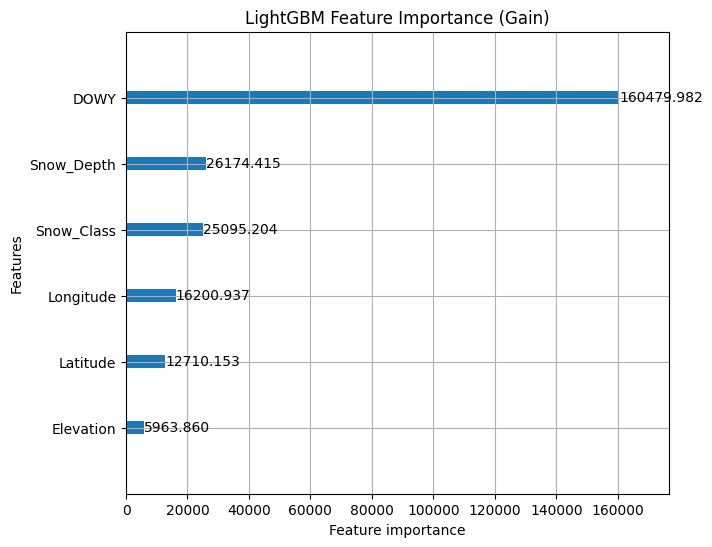

In [70]:
from matplotlib import pyplot as plt
# Plot feature importance using Split
lgb.plot_importance(lgbm_main, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

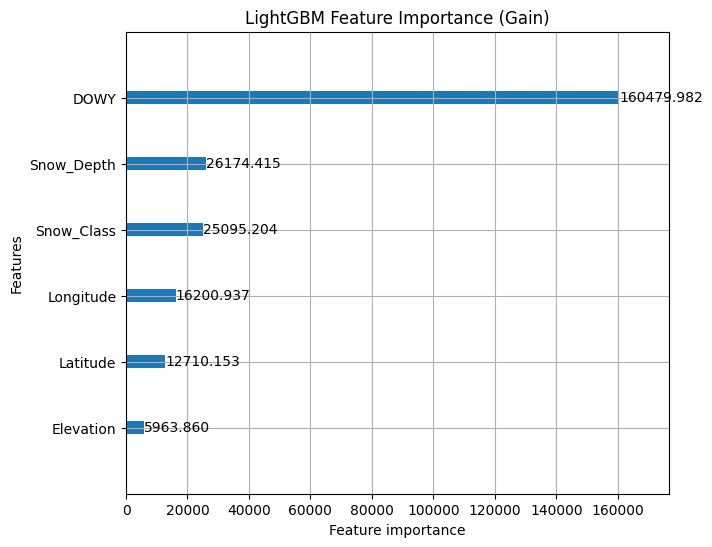

In [40]:
from matplotlib import pyplot as plt
# Plot feature importance using Split
lgb.plot_importance(lgbm_main, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [7]:
import shap


explainer = shap.TreeExplainer(lgbm_main)
shap_values = explainer(X_test_main)

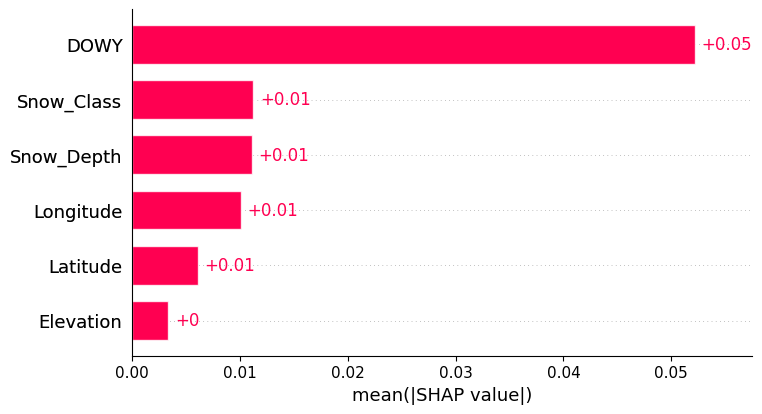

In [10]:
shap.plots.bar(shap_values)

In [16]:
# shap.plots.bar(shap_values.abs.max(0))

### XGBoost

In [11]:
with open('../experiments/results/tune_new/xgboost_main_tune_target_20250902_200431.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

sampling_method = "gradient_based" if xgb_device == "cuda" else "uniform"
default_params_xgb = {
    "objective": "reg:squarederror",
    "seed": all_config.global_cfg.seed,
    "tree_method": "hist",
    "device": xgb_device,
    "verbosity": 0,
    "sampling_method": sampling_method
}


xgb_params_from_optuna=raw_config['performance']['hyperparameters']
xgb_params_from_optuna.update(default_params_xgb)

dtrain = xgb.DMatrix(X_train_main, label=y_train)
dtest = xgb.DMatrix(X_test_main)

xgb_main = xgb.train(
    xgb_params_from_optuna,
    dtrain,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'], 
)

y_pred_xgb_main = xgb_main.predict(dtest)

In [ ]:
pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": xgb_main.get_score(importance_type='gain').values()
        }
).sort_values(by="Importance", ascending=False)

,Feature,Importance
2,DOWY,93.200340
5,Snow_Class,42.732197
1,Snow_Depth,8.157521
4,Longitude,4.461824
3,Latitude,3.258300
0,Elevation,2.267700


In [37]:
pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": xgb_main.get_score(importance_type='total_gain').values()
        }
    ).sort_values(by="Importance", ascending=False)

,Feature,Importance
2,DOWY,176521.437500
1,Snow_Depth,28657.371094
5,Snow_Class,27861.392578
4,Longitude,17753.599609
3,Latitude,11765.719727
0,Elevation,5680.587891


## Model Comparison

* Density

In [11]:
main_model_results=pd.DataFrame({
    'EXT_Density': y_pred_ext_main,
    'RF_Density': y_pred_rf_main,
    'LGBM_Density': y_pred_lgbm_main,
    'XGB_Density': y_pred_xgb_main,
    'True_Density': y_test.values
})

main_model_results.head()

,EXT_Density,RF_Density,LGBM_Density,XGB_Density,True_Density
0,0.274272,0.247755,0.254605,0.258287,0.308333
1,0.270857,0.248233,0.256336,0.260336,0.264286
2,0.277096,0.248691,0.263672,0.267221,0.300000
3,0.279963,0.259595,0.267992,0.270378,0.300000
4,0.278483,0.266122,0.270703,0.271092,0.278571


In [12]:
compare_multiple_models(main_model_results, 'True_Density')

,EXT_Density,RF_Density,LGBM_Density,XGB_Density
RMSE,0.051531,0.052996,0.051216,0.051265
MBE,0.001152,0.002019,0.001910,0.002285
RSQ,0.680795,0.662381,0.684689,0.684076


* SWE

In [13]:
main_model_swe_results=pd.DataFrame({
    'EXT_SWE': main_model_results.EXT_Density.values*X_test_main.Snow_Depth.values,
    'RF_SWE': main_model_results.RF_Density.values*X_test_main.Snow_Depth.values,
    'LGBM_SWE': main_model_results.LGBM_Density.values*X_test_main.Snow_Depth.values,
    'XGB_SWE': main_model_results.XGB_Density.values*X_test_main.Snow_Depth.values,
    'True_SWE': raw_data.x_val.SWE.values,
})

main_model_swe_results.head()

,EXT_SWE,RF_SWE,LGBM_SWE,XGB_SWE,True_SWE
0,8.359807,7.551563,7.760360,7.872575,9.398
1,9.631689,8.827179,9.115292,9.257566,9.398
2,9.149716,8.211768,8.706452,8.823651,9.906
3,9.244391,8.571824,8.849098,8.927877,9.906
4,9.902841,9.463315,9.626202,9.640039,9.906


In [14]:
compare_multiple_models(main_model_swe_results, 'True_SWE')

,EXT_SWE,RF_SWE,LGBM_SWE,XGB_SWE
RMSE,5.493810,5.752251,5.393536,5.349604
MBE,0.075129,0.117492,0.171727,0.188284
RSQ,0.964327,0.960892,0.965618,0.966175


* LightGBM for the Win - it did slightly better in density estimation.

## Adding Climatology

### Extra Trees

In [19]:
climate7d_config = model_variant_selector(variant='climate_7d', data=raw_data)

processed_data_cat_7d=ecnoder_preprocessor(
    encoder='target',
    cfg=all_config.global_cfg,
    data=climate7d_config
)


X_train_7d = processed_data_cat_7d.x_train
X_test_7d = processed_data_cat_7d.x_val

In [20]:
with open('../experiments/results/tune_new/extratrees_climate_7d_tune_target_20250902_232842.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

ext_hyp_from_optuna = raw_config['performance']['hyperparameters']


ext_trees_7=ExtraTreesRegressor(**ext_hyp_from_optuna, random_state=all_config.global_cfg.seed, n_jobs=all_config.global_cfg.n_jobs)

ext_trees_7.fit(X_train_7d, y_train)
y_pred_ext_7 = ext_trees_7.predict(X_test_7d)

In [79]:
ext_trees

NameError: name 'ext_trees' is not defined

### Random Forest

In [21]:
with open('../experiments/results/tune_new/rf_climate_7d_tune_target_20250902_232842.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

rf_hyp_from_optuna = raw_config['performance']['hyperparameters']


rf_trees_7=RandomForestRegressor(**rf_hyp_from_optuna, random_state=all_config.global_cfg.seed, n_jobs=all_config.global_cfg.n_jobs)

rf_trees_7.fit(X_train_7d, y_train)
y_pred_rf_7 = rf_trees_7.predict(X_test_7d)

### LightGBM

In [71]:
with open('../experiments/results/tune_new/lightgbm_climate_7d_tune_target_20250902_200431.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

default_params= {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': all_config.global_cfg.seed,
    "force_col_wise": True,
    "verbosity": all_config.global_cfg.verbosity,
    "deterministic": True
}

params_from_optuna = raw_config['performance']['hyperparameters']
params_from_optuna.update(default_params)

train_data = lgb.Dataset(X_train_7d, label=y_train)

lgbm_7 = lgb.train(
    params_from_optuna,
    train_data,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'] # best iteration from Optuna
)

y_pred_lgbm_7 = lgbm_7.predict(X_test_7d)

In [72]:
raw_config['performance']['metrics']['best_iteration'], params_from_optuna

(99,
 {'num_leaves': 202,
  'learning_rate': 0.04239942996444115,
  'min_child_samples': 86,
  'reg_alpha': 1.0290351857869753e-05,
  'reg_lambda': 0.005880313324688824,
  'max_depth': 9,
  'objective': 'regression',
  'metric': 'rmse',
  'random_state': 10,
  'force_col_wise': True,
  'verbosity': -1,
  'deterministic': True})

### XGBoost

In [23]:
with open('../experiments/results/tune_new/xgboost_climate_7d_tune_target_20250902_200431.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

sampling_method = "gradient_based" if xgb_device == "cuda" else "uniform"
default_params_xgb = {
    "objective": "reg:squarederror",
    "seed": all_config.global_cfg.seed,
    "tree_method": "hist",
    "device": xgb_device,
    "verbosity": 0,
    "sampling_method": sampling_method
}


xgb_params_from_optuna=raw_config['performance']['hyperparameters']
xgb_params_from_optuna.update(default_params_xgb)

dtrain = xgb.DMatrix(X_train_7d, label=y_train)
dtest = xgb.DMatrix(X_test_7d)

xgb_7 = xgb.train(
    xgb_params_from_optuna,
    dtrain,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'], 
)

y_pred_xgb_7 = xgb_7.predict(dtest)

In [24]:
pd.DataFrame(
        data={
            "Feature": xgb_7.feature_names,
            "Importance": xgb_7.get_score(importance_type='gain').values()
        }
    ).sort_values(by="Importance", ascending=False)

,Feature,Importance
2,DOWY,47.599949
6,TAVG_lag_7d,24.069271
7,Snow_Class,10.142427
1,Snow_Depth,7.120821
4,Longitude,2.119342
5,PRECIPITATION_lag_7d,1.862609
3,Latitude,1.591218
0,Elevation,1.162162


## Model Comparison

In [27]:
climate_density_results=pd.DataFrame({
    'EXT_Density_climate': y_pred_ext_7,
    'RF_Density_climate': y_pred_rf_7,
    'LGBM_Density_climate': y_pred_lgbm_7,
    'XGB_Density_climate': y_pred_xgb_7,
    'True_Density': y_test.values
})

climate_density_results.head()

,EXT_Density_climate,RF_Density_climate,LGBM_Density_climate,XGB_Density_climate,True_Density
0,0.266471,0.247584,0.239944,0.240130,0.308333
1,0.266803,0.247646,0.238482,0.239190,0.264286
2,0.268182,0.247646,0.242394,0.244625,0.300000
3,0.269955,0.247646,0.246544,0.249720,0.300000
4,0.270879,0.247646,0.249270,0.250659,0.278571


In [28]:
compare_multiple_models(climate_density_results, 'True_Density')

,EXT_Density_climate,RF_Density_climate,LGBM_Density_climate,XGB_Density_climate
RMSE,0.048647,0.049515,0.048000,0.048148
MBE,0.001702,0.001681,0.002265,0.002721
RSQ,0.715522,0.705277,0.723036,0.721324


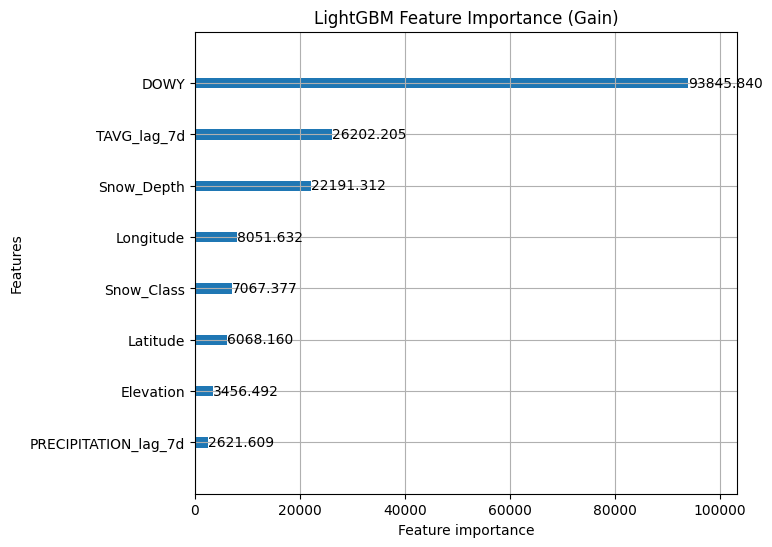

In [29]:
from matplotlib import pyplot as plt
# Plot feature importance using Split
lgb.plot_importance(lgbm_7, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [25]:
import shap

explainer_7 = shap.TreeExplainer(lgbm_7)
shap_values_7 = explainer_7(X_test_7d)

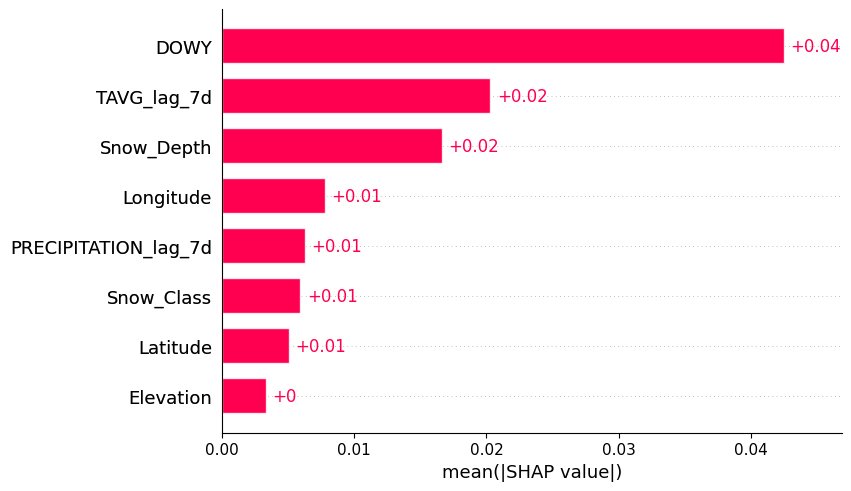

In [26]:
shap.plots.bar(shap_values_7)

In [30]:
climate_swe_results=pd.DataFrame({
    'True_SWE': raw_data.x_val.SWE.values,
    'EXT_SWE_climate': climate_density_results.EXT_Density_climate.values*X_test_7d.Snow_Depth.values,
    'RF_SWE_climate': climate_density_results.RF_Density_climate.values*X_test_7d.Snow_Depth.values,
    'LGBM_SWE_climate': climate_density_results.LGBM_Density_climate.values*X_test_7d.Snow_Depth.values,
    'XGB_SWE_climate': climate_density_results.XGB_Density_climate.values*X_test_7d.Snow_Depth.values,
})

climate_swe_results.head()

,True_SWE,EXT_SWE_climate,RF_SWE_climate,LGBM_SWE_climate,XGB_SWE_climate
0,9.398,8.122034,7.546353,7.313485,7.319155
1,9.398,9.487531,8.806277,8.480415,8.505586
2,9.906,8.855378,8.177257,8.003835,8.077516
3,9.906,8.913913,8.177257,8.140875,8.245748
4,9.906,9.632469,8.806277,8.864030,8.913432


In [31]:
compare_multiple_models(climate_density_results, 'True_Density')

,EXT_Density_climate,RF_Density_climate,LGBM_Density_climate,XGB_Density_climate
RMSE,0.048647,0.049515,0.048000,0.048148
MBE,0.001702,0.001681,0.002265,0.002721
RSQ,0.715522,0.705277,0.723036,0.721324


In [32]:
compare_multiple_models(climate_swe_results, 'True_SWE')

,EXT_SWE_climate,RF_SWE_climate,LGBM_SWE_climate,XGB_SWE_climate
RMSE,5.063582,5.453277,5.028539,5.012549
MBE,0.123620,0.128247,0.212589,0.259325
RSQ,0.969696,0.964852,0.970114,0.970303


In [54]:
import seaborn as sns

In [73]:
shap_importance_main=(
    pd.DataFrame(
        data={
            "Feature": lgbm_main.feature_name(),
            "Importance": np.abs(shap_values.values).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow Depth': 'Snow Depth',
    })
)

shap_importance_main

,Feature,Importance
2,DOWY,0.052164
5,Snow Class,0.011241
1,Snow_Depth,0.011115
4,Longitude,0.010083
3,Latitude,0.006069
0,Elevation,0.003332


In [74]:
shap_importance_climate=(
    pd.DataFrame(
        data={
            "Feature": lgbm_7.feature_name(),
            "Importance": np.abs(shap_values_7.values).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_7d': r'$\bar{t}_{-7}$',
        'PRECIPITATION_lag_7d': r'$\bar{p}_{-7}$'
    })
)

shap_importance_climate

,Feature,Importance
2,DOWY,0.042484
6,$\bar{t}_{-7}$,0.020289
1,Snow Depth,0.016626
4,Longitude,0.007769
5,$\bar{p}_{-7}$,0.006288
7,Snow Class,0.005933
3,Latitude,0.005084
0,Elevation,0.003326


In [75]:
splits = lgbm_main.feature_importance(importance_type='split')
gains = lgbm_main.feature_importance(importance_type='gain')
average_gain = np.divide(gains, splits, out=np.zeros_like(gains), where=splits!=0)

# Normalize to sum to 1
normalized_gain = average_gain / average_gain.sum()

xgboost_gain_main = (
    pd.DataFrame(
        data={
            "Feature": lgbm_main.feature_name(),
            "Importance": normalized_gain  # Use normalized values
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
    })
)

xgboost_gain_main

,Feature,Importance
2,DOWY,0.643154
5,Snow Class,0.239762
1,Snow Depth,0.059232
4,Longitude,0.024709
3,Latitude,0.020585
0,Elevation,0.012558


In [76]:
splits_7 = lgbm_7.feature_importance(importance_type='split')
gains_7 = lgbm_7.feature_importance(importance_type='gain')
average_gain_7 = np.divide(gains_7, splits_7, out=np.zeros_like(gains_7), where=splits_7!=0)

normalized_gain_7 = average_gain_7 / average_gain_7.sum()

xgboost_gain_climate=(
    pd.DataFrame(
        data={
            "Feature": lgbm_7.feature_name(),
            "Importance": normalized_gain_7
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_7d': r'$\bar{t}_{-7}$',
        'PRECIPITATION_lag_7d': r'$\bar{p}_{-7}$'
    })
)

xgboost_gain_climate

,Feature,Importance
2,DOWY,0.499621
6,$\bar{t}_{-7}$,0.246644
7,Snow Class,0.108385
1,Snow Depth,0.075651
4,Longitude,0.021687
5,$\bar{p}_{-7}$,0.019921
3,Latitude,0.016720
0,Elevation,0.011372


In [77]:
from matplotlib.ticker import MultipleLocator

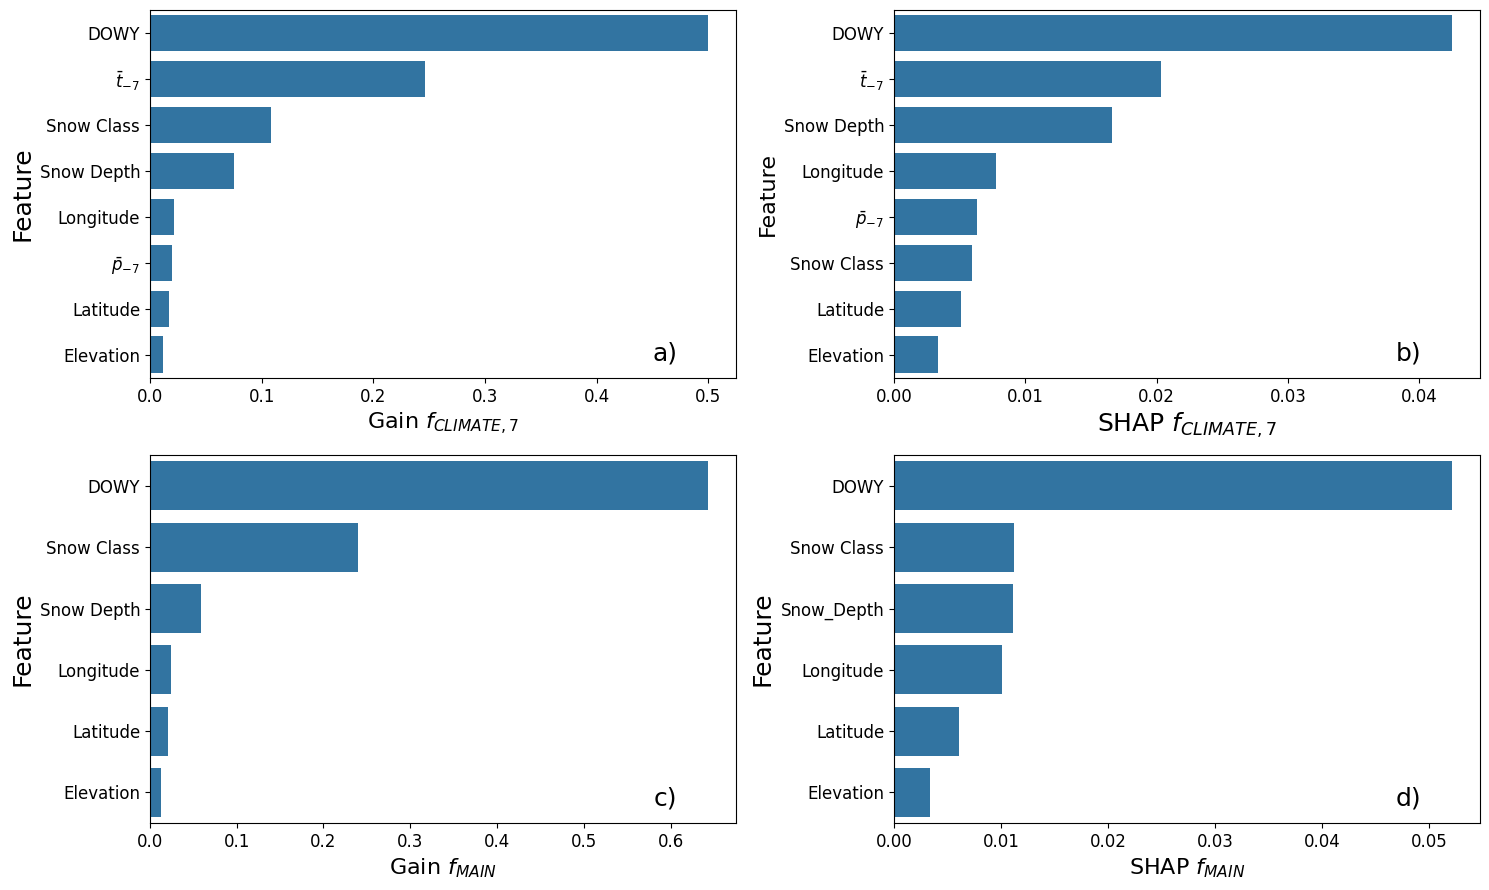

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

sns.barplot(x="Importance", y="Feature", data=xgboost_gain_climate, ax=ax[0, 0])
ax[0, 0].set_xlabel("Gain $f_{CLIMATE, 7}$", fontsize=16)
ax[0, 0].set_ylabel("Feature", fontsize=18)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].text(0.90, 0.10, 'a)', transform=ax[0, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_climate, ax=ax[0, 1])
ax[0, 1].set_xlabel("SHAP $f_{CLIMATE, 7}$", fontsize=18)
ax[0, 1].set_ylabel("Feature", fontsize=16)
ax[0, 1].tick_params(labelsize=12)
ax[0, 1].xaxis.set_major_locator(MultipleLocator(0.01))
ax[0, 1].text(0.90, 0.10, 'b)', transform=ax[0, 1].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=xgboost_gain_main, ax=ax[1, 0])
ax[1, 0].set_xlabel("Gain $f_{MAIN}$", fontsize=16)
ax[1, 0].set_ylabel("Feature", fontsize=18)
ax[1, 0].tick_params(labelsize=12)
ax[1, 0].text(0.90, 0.10, 'c)', transform=ax[1, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_main, ax=ax[1, 1])
ax[1, 1].set_xlabel("SHAP $f_{MAIN}$", fontsize=16)
ax[1, 1].set_ylabel("Feature", fontsize=18)
ax[1, 1].tick_params(labelsize=12)
ax[1, 1].text(0.90, 0.10, 'd)', transform=ax[1, 1].transAxes, fontsize=18, va='top', ha='right')

plt.tight_layout()
plt.savefig('../plots/figure10.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Climate 14

### LightGBM Wins!

We'll save the model weights and encoder for later use.

In [25]:
if not os.path.exists('../ML_weights'):
    os.makedirs('../ML_weights')
else:
    print('Folder already exists')

Folder already exists


In [26]:
xgb_main.save_model("../ML_weights/main_density_model.ubj") # Non climate
xgb_climate.save_model("../ML_weights/climate_density_model.ubj") # Climate Enhanced

In [27]:
# Save the encoders to a file
with open('../ML_weights/encoder_climate.pkl', 'wb') as f:
    pickle.dump(encoder_climate, f)

with open('../ML_weights/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

### Store Predictions

In [33]:
main_model_results.drop('True_Density', axis=1).to_parquet('../results/density/ML_models_predictions_baseline.parquet', index=False, compression='gzip')
main_model_swe_results.drop('True_SWE', axis=1).to_parquet('../results/swe/ML_models_predictions_baseline.parquet', index=False, compression='gzip')

In [34]:
climate_density_results.drop('True_Density', axis=1).to_parquet('../results/density/ML_models_predictions_climate.parquet', index=True, compression='gzip')
climate_swe_results.drop('True_SWE', axis=1).to_parquet('../results/swe/ML_models_predictions_climate.parquet', index=True, compression='gzip')

# The End!